In [42]:
import nltk
nltk.download()
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [18]:
debug = True

## Part 1: Data

### Load dataset

In [29]:
messages = pd.read_table("data/training.txt", header=None, names=['label', 'message'])

In [30]:
if debug:
    print(messages.head())

   label                                            message
0      1  La noticia de WhatsApp , aplicación de mensaje...
1      0  En cualquier caso , aunque la respeto mucho Fr...
2      0  Entre los 320 individuos de actuación son el m...
3      1  Tal vez ella vaya a tomar aunque sea alguno de...
4      1  Ella ha hecho mucho por las mujeres en la músi...


## Part 2: Basic Exploratory Data Analysis

In [32]:
messages.groupby('label').describe()

message
label                                                          
0     count                                                8449
      unique                                               8449
      top     ¿ Eso quiere decir que estas mujeres heterosex...
      freq                                                    1
1     count                                                8443
      unique                                               8443
      top     Y él dice que las justificaciones del mundo re...
      freq                                                    1

In [33]:
messages['length'] = messages['message'].apply(len)
if debug:
    print(messages.head())

   label                                            message  length
0      1  La noticia de WhatsApp , aplicación de mensaje...     212
1      0  En cualquier caso , aunque la respeto mucho Fr...     457
2      0  Entre los 320 individuos de actuación son el m...      89
3      1  Tal vez ella vaya a tomar aunque sea alguno de...      84
4      1  Ella ha hecho mucho por las mujeres en la músi...     107


Let's visualize this!

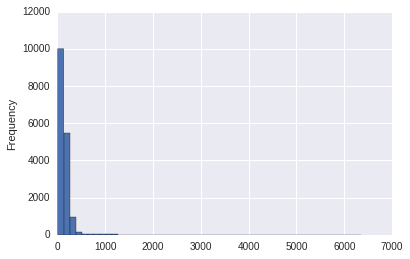

In [35]:
messages['length'].plot(bins=50, kind='hist')

In [36]:
messages.length.describe()

count    16892.000000
mean       151.071632
std        222.740425
min          7.000000
25%         69.000000
50%        114.000000
75%        173.000000
max       6353.000000
Name: length, dtype: float64

In [38]:
#messages[messages['length'] == 6353]['message'].iloc[0]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f829eb451d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f8292f9e7b8>], dtype=object)

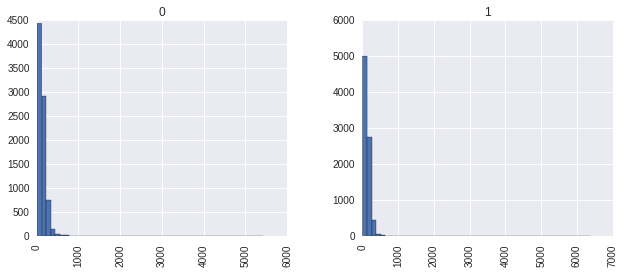

In [39]:
messages.hist(column='length', by='label', bins=50,figsize=(10,4))

## Part 3: Text pre-processing

In this section we'll massage the raw messages (sequence of characters) into vectors (sequences of numbers).
As a first step, let's write a function that will split a message into its individual words and return a list. We'll also remove very common words, ('the', 'a', etc..). To do this we will take advantage of the NLTK library. 

In [48]:
import string
from nltk.corpus import stopwords
stopwords.words('spanish')[0:10] # Show some stop words

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se']

In [82]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    #In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("spanish"))  
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stops]

#### OUTRA FUNÇÃO DE PROCESSAMENTO POSSÍVEL

In [81]:
def review_to_words( raw_review ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review).get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words )) 

In [80]:
# Check to make sure its working
messages['message'].head(5).apply(text_process)

0    [noticia, WhatsApp, aplicación, mensajería, gr...
1    [cualquier, caso, aunque, respeto, Fred, permí...
2    [320, individuos, actuación, ministro, Interio...
3    [Tal, vez, vaya, tomar, aunque, alguno, consej...
4    [hecho, mujeres, música, country, siempre, pun...
Name: message, dtype: object

### Continuing Normalization

There are a lot of ways to continue normalizing this text. Such as Stemming or distinguishing by [part of speech](http://www.nltk.org/book/ch05.html).
NLTK has lots of built-in tools and great documentation on a lot of these methods. Sometimes they don't work well for text-messages due to the way a lot of people tend to use abbreviations or shorthand, For example:
'Nah dawg, IDK! Wut time u headin to da club?'

versus
'No dog, I don't know! What time are you heading to the club?'

Some text normalization methods will have trouble with this type of shorthand and so I'll leave you to explore those more advanced methods through the [NLTK book online](http://www.nltk.org/book/).

## Part 4: Vectorization

Convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.
We'll do that in three steps using the bag-of-words model:
Count how many times does a word occur in each message (Known as term frequency)
Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)
Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

We will first use SciKit Learn's CountVectorizer. This model will convert a collection of text documents to a matrix of token counts.

In [57]:
from sklearn.feature_extraction.text import CountVectorizer

In [84]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(messages['message'])

if debug:
    # Print total number of vocab words
    print(len(bow_transformer.vocabulary_))
    # Take a look at the words in the vocabulary
    vocab = bow_transformer.get_feature_names()
    print(vocab)

29760
['0', '00', '000', '0001', '0014', '0021', '0075', '00Un', '01', '011', '02', '03', '04', '05', '06', '07', '09', '1', '10', '100', '1000', '10000', '100000', '1000000', '10000000', '100000000', '1003', '100K', '100M', '100s', '101', '1015', '102', '1024', '102700', '105', '10500', '1057', '1062', '108', '108000000', '109', '1090', '109000', '1099', '1099s', '10M', '10k', '11', '110', '114', '116', '12', '120', '120000', '122', '1223', '124', '125', '129', '13', '13000', '133', '134', '13400', '135', '13M', '13bn', '13episodios', '14', '140', '14000', '1438', '144', '144000', '145', '147', '1489', '14k', '15', '150', '1500', '15000', '150000', '155', '156', '158', '159', '15W', '15k', '16', '160', '16000', '1600000', '162k', '164', '16400000000', '16492', '1650', '168', '16k', '17', '170', '1700', '1789', '17o', '18', '1800', '183', '1830000000', '1840', '185300', '185m', '18th', '19', '1900', '190000', '1901', '1906', '1923', '1929', '193', '1930', '1931', '1938', '1940', '1941'

Let's take one text message and get its bag-of-words counts as a vector, putting to use our new bow_transformer:

In [61]:
message4 = messages['message'][3]
if debug:
    print(message4)

Tal vez ella vaya a tomar aunque sea alguno de los consejos de su madrina en serio !


In [62]:
bow4 = bow_transformer.transform([message4])
if debug:
    print(bow4)
    print(bow4.shape)

  (0, 7938)	1
  (0, 9745)	1
  (0, 10884)	1
  (0, 13328)	1
  (0, 21192)	1
  (0, 27019)	1
  (0, 28320)	1
  (0, 29057)	1
  (0, 29243)	1
(1, 29760)


This means that there are nine unique words in message number 4 (after removing common stop words). All of them appear only once. 

Now we can use .transform on our Bag-of-Words (bow) transformed object and transform the entire DataFrame of messages. Let's go ahead and check out how the bag-of-words counts for the entire SMS corpus is a large, sparse matrix:

In [64]:
messages_bow = bow_transformer.transform(messages['message'])
if debug:
    print('Shape of Sparse Matrix: ', messages_bow.shape)
    print('Amount of Non-Zero occurences: ', messages_bow.nnz)
    print('sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1])))

Shape of Sparse Matrix:  (16892, 29760)
Amount of Non-Zero occurences:  217970
sparsity: 0.04%


After the counting, the term weighting and normalization can be done with TF-IDF, using scikit-learn's TfidfTransformer.

In [66]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
if debug:
    print(tfidf4)

  (0, 29243)	0.196504907553
  (0, 29057)	0.359236608475
  (0, 28320)	0.273517742569
  (0, 27019)	0.316333484939
  (0, 21192)	0.431378169134
  (0, 13328)	0.376392311463
  (0, 10884)	0.27627900605
  (0, 9745)	0.394105268809
  (0, 7938)	0.313127293964


To transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [67]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
if debug:
    print(messages_tfidf.shape)

(16892, 29760)


There are many ways the data can be preprocessed and vectorized. These steps involve feature engineering and building a "pipeline". I encourage you to check out SciKit learn's documentation on dealing with text data as well as the expansive collection of availble papers and books on the general topic of NLP.

## Part 5: Training a model
With messages represented as vectors, we can finally train our spam/ham classifier. Now we can actually use almost any sort of classification algorithms. For a variety of reasons, the Naive Bayes classifier algorithm is a good choice.

In [68]:
from sklearn.naive_bayes import MultinomialNB
human_detect_model = MultinomialNB().fit(messages_tfidf, messages['label'])

Let's try classifying our single random message and checking how we do:

In [71]:
if debug:
    print('predicted:', human_detect_model.predict(tfidf4)[0])
    print('expected:', messages.label[3])

predicted: 0
expected: 1


### Using Random Forest

In [85]:
print("Training the random forest...")
from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 100) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
forest = forest.fit(messages_tfidf, messages["label"])

Training the random forest...


## Part 6: Model Evaluation
Now we want to determine how well our model will do overall on the entire dataset. Let's beginby getting all the predictions:

In [72]:
all_predictions = human_detect_model.predict(messages_tfidf)
if debug:
    print(all_predictions)

[0 0 0 ..., 0 0 0]


We can use SciKit Learn's built-in classification report, which returns precision, recall, f1-score, and a column for support (meaning how many cases supported that classification). 

In [73]:
from sklearn.metrics import classification_report
if debug:
    print(classification_report(messages['label'], all_predictions))

             precision    recall  f1-score   support

          0       0.75      0.87      0.80      8449
          1       0.84      0.71      0.77      8443

avg / total       0.80      0.79      0.79     16892



In the above "evaluation",we evaluated accuracy on the same data we used for training. You should never actually evaluate on the same dataset you train on!


A proper way is to split the data into a training/test set, where the model only ever sees the training data during its model fitting and parameter tuning. The test data is never used in any way. This is then our final evaluation on test data is representative of true predictive performance.

### Random forest evaluation

In [86]:
all_predictions_forest = forest.predict(messages_tfidf)
if debug:
    print(all_predictions_forest)
    print(classification_report(messages['label'], all_predictions_forest))

[1 0 0 ..., 0 1 0]
             precision    recall  f1-score   support

          0       0.95      0.95      0.95      8449
          1       0.95      0.95      0.95      8443

avg / total       0.95      0.95      0.95     16892



## Split dataset (train and test)

In [74]:
from sklearn.cross_validation import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(messages['message'], messages['label'], test_size=0.2)

if debug:
    print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

13513 3379 16892


The test size is 20% of the entire dataset (3379 messages out of total 16892), and the training is the rest (13513 out of 16892). Note the default split would have been 30/70.

## Part 7: Creating a Data Pipeline

In [75]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [76]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow', CountVectorizer(analyzer=<function text_process at 0x7f828f9149d8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=No...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [77]:
predictions = pipeline.predict(msg_test)

In [78]:
if debug:
    print(classification_report(predictions,label_test))

             precision    recall  f1-score   support

          0       0.43      0.36      0.39      1985
          1       0.26      0.32      0.29      1394

avg / total       0.36      0.34      0.35      3379

